In [1]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
#!kaggle datasets download -d sshikamaru/lyme-disease-rashes

In [3]:
#!unzip lyme-disease-rashes.zip

### 1. Exploratory Data Analysis

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("RashData/Train/Train_2_Cases")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))
positive = file_count.count('Lyme_Positive')
negative = file_count.count('Lyme_Negative')

In [5]:
!pwd

/ibex/scratch/qunberas/lyme


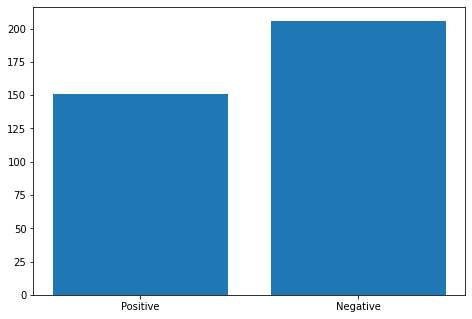

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Positive','Negative']
count_train = [positive, negative]
ax.bar(labels, count_train)
plt.show()

In [7]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(357, 2)


In [8]:
# test
path = Path("RashData/Validation/Validation_2_Cases")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))

test = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
test = test.sample(frac=1).reset_index(drop=True)
print(np.shape(test))

(87, 2)


In [9]:
train = train.append(test, ignore_index=True)

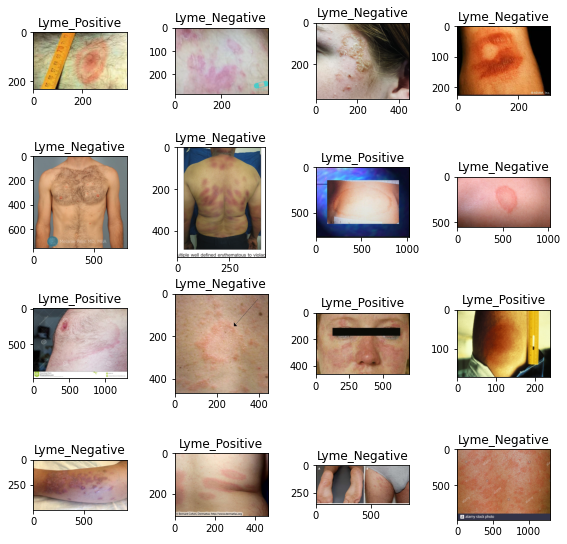

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1): 
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [11]:
# hparams = AttrDict(
#     image_size=(128, 128, 3),
#     n_classes=len(labels),
#     batch_size=64,
# )

# ds = tf.keras.preprocessing.image_dataset_from_directory("/ibex/scratch/qunberas/dataset_chest/train", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
# train_split = round(0.8 * ds.cardinality().numpy()) 
# train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
# validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

In [12]:
!nvidia-smi

Tue Jul  6 11:57:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   

In [13]:
## train_test structure
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=len(labels),
    batch_size=64,
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory("RashData/Train/Train_2_Cases", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory("RashData/Validation/Validation_2_Cases", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)

 

Found 357 files belonging to 2 classes.
Found 87 files belonging to 2 classes.


In [14]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

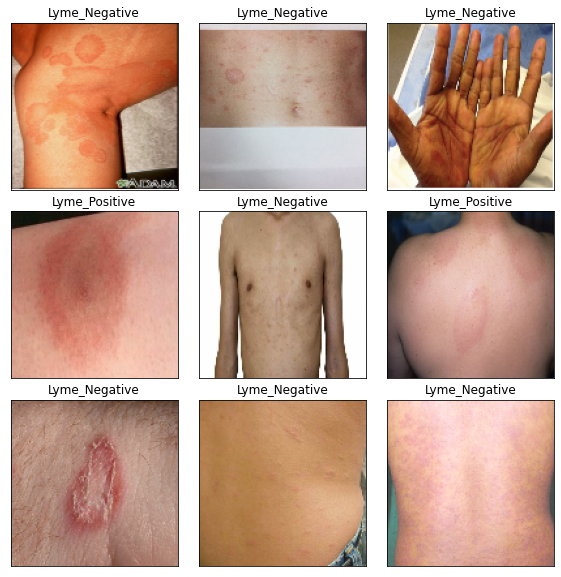

In [15]:
_ = plot_grid_ds(train_ds)

In [16]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.a

In [22]:
model.fit(train_ds, epochs=100, validation_data=validation_ds)

Epoch 1/100
6/6 [==============================] - 4s 386ms/step - loss: 0.6386 - accuracy: 0.6275 - balanced_sparse_categorical_accuracy: 0.5932 - val_loss: 0.6353 - val_accuracy: 0.6667 - val_balanced_sparse_categorical_accuracy: 0.5860
Epoch 2/100
6/6 [==============================] - 7s 313ms/step - loss: 0.5944 - accuracy: 0.6807 - balanced_sparse_categorical_accuracy: 0.6663 - val_loss: 0.6403 - val_accuracy: 0.6207 - val_balanced_sparse_categorical_accuracy: 0.5594
Epoch 3/100
6/6 [==============================] - 5s 348ms/step - loss: 0.5617 - accuracy: 0.7143 - balanced_sparse_categorical_accuracy: 0.6779 - val_loss: 0.6600 - val_accuracy: 0.5057 - val_balanced_sparse_categorical_accuracy: 0.5718
Epoch 4/100
6/6 [==============================] - 4s 337ms/step - loss: 0.5840 - accuracy: 0.6807 - balanced_sparse_categorical_accuracy: 0.6433 - val_loss: 0.6046 - val_accuracy: 0.6897 - val_balanced_sparse_categorical_accuracy: 0.7121
Epoch 5/100
6/6 [===========================

6/6 [==============================] - 5s 360ms/step - loss: 0.2216 - accuracy: 0.9188 - balanced_sparse_categorical_accuracy: 0.9224 - val_loss: 0.6217 - val_accuracy: 0.7701 - val_balanced_sparse_categorical_accuracy: 0.7411
Epoch 36/100
6/6 [==============================] - 5s 347ms/step - loss: 0.2391 - accuracy: 0.8936 - balanced_sparse_categorical_accuracy: 0.8867 - val_loss: 0.5738 - val_accuracy: 0.7356 - val_balanced_sparse_categorical_accuracy: 0.7122
Epoch 37/100
6/6 [==============================] - 4s 337ms/step - loss: 0.1782 - accuracy: 0.9384 - balanced_sparse_categorical_accuracy: 0.9373 - val_loss: 0.5896 - val_accuracy: 0.7586 - val_balanced_sparse_categorical_accuracy: 0.7078
Epoch 38/100
6/6 [==============================] - 4s 298ms/step - loss: 0.1989 - accuracy: 0.9244 - balanced_sparse_categorical_accuracy: 0.9150 - val_loss: 0.6045 - val_accuracy: 0.7701 - val_balanced_sparse_categorical_accuracy: 0.7238
Epoch 39/100
6/6 [==============================] - 4

6/6 [==============================] - 5s 359ms/step - loss: 0.0596 - accuracy: 0.9804 - balanced_sparse_categorical_accuracy: 0.9789 - val_loss: 1.0615 - val_accuracy: 0.7011 - val_balanced_sparse_categorical_accuracy: 0.6586
Epoch 70/100
6/6 [==============================] - 5s 334ms/step - loss: 0.1010 - accuracy: 0.9664 - balanced_sparse_categorical_accuracy: 0.9684 - val_loss: 1.3325 - val_accuracy: 0.6782 - val_balanced_sparse_categorical_accuracy: 0.6829
Epoch 71/100
6/6 [==============================] - 5s 409ms/step - loss: 0.1369 - accuracy: 0.9412 - balanced_sparse_categorical_accuracy: 0.9437 - val_loss: 0.8423 - val_accuracy: 0.7816 - val_balanced_sparse_categorical_accuracy: 0.7878
Epoch 72/100
6/6 [==============================] - 5s 333ms/step - loss: 0.0613 - accuracy: 0.9692 - balanced_sparse_categorical_accuracy: 0.9761 - val_loss: 0.7722 - val_accuracy: 0.7931 - val_balanced_sparse_categorical_accuracy: 0.7981
Epoch 73/100
6/6 [==============================] - 4

## 3. Results

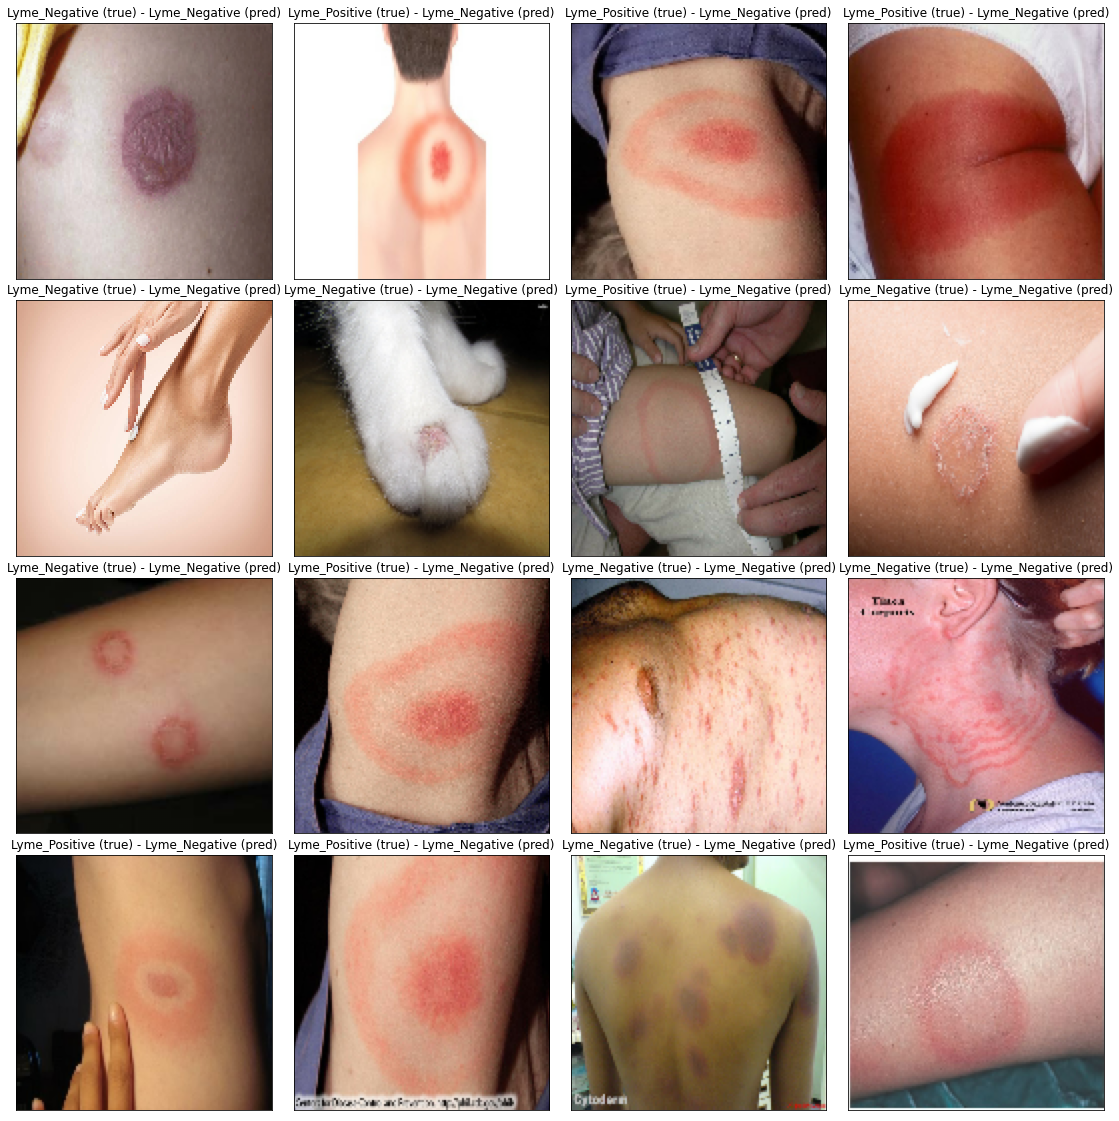

In [18]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[51,  0],
       [34,  2]])

In [20]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.528


In [21]:
model.save("models/ViT_on_10_epochs.model")

INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets


INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets
